In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

In [75]:
evaluation_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1-step=11176_test_results.json'


In [76]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(scores['precision']), float(scores['f1'])])
    print(table)

In [77]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        auc_scores = {'mean_auc': data[dataset]['auc']}
        auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl", rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--', label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score', title=f'AUC Scores per Class for {dataset}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [78]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}
    
    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [79]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(data['jigsaw'], data['secondary_neutral'])

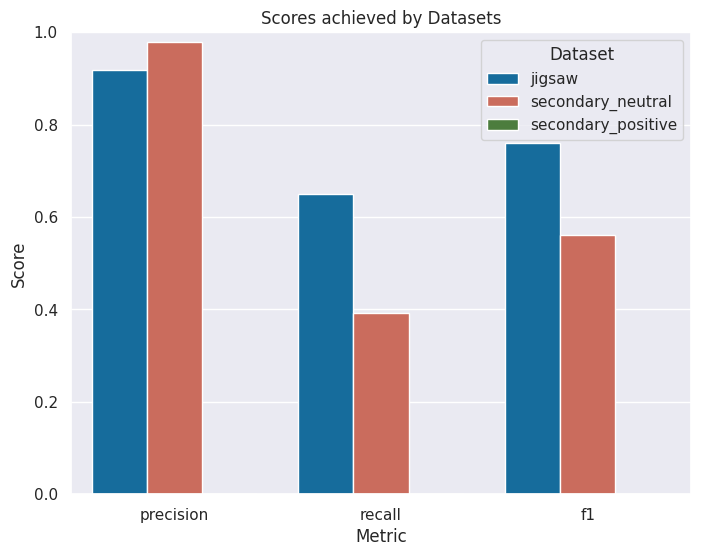

+--------------------+--------+-----------+--------+
|      Dataset       | Recall | Precision |   F1   |
+--------------------+--------+-----------+--------+
|       jigsaw       | 0.6494 |   0.9183  | 0.7608 |
| secondary_neutral  | 0.3929 |   0.9792  | 0.5608 |
| secondary_positive |  0.0   |    0.0    |  0.0   |
+--------------------+--------+-----------+--------+


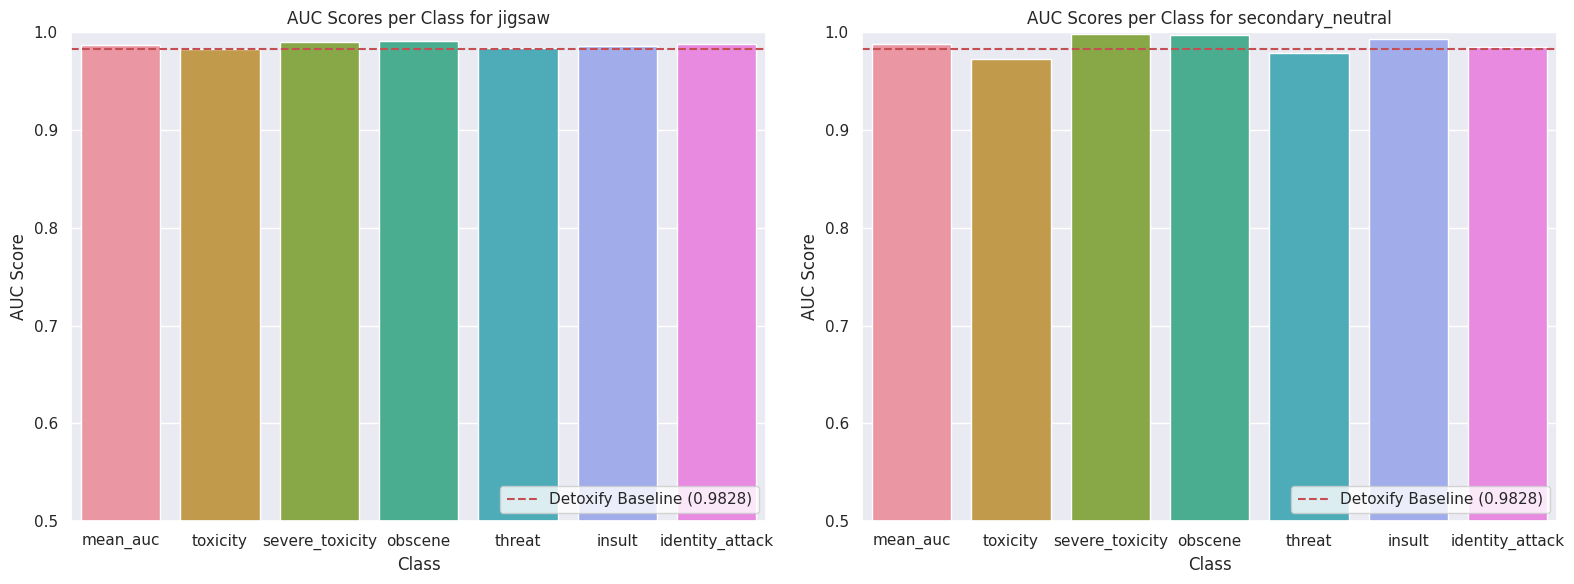

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9871 |       0.9876      |
|     toxicity    | 0.9831 |       0.9729      |
| severe_toxicity | 0.9905 |       0.9983      |
|     obscene     | 0.9912 |       0.9977      |
|      threat     | 0.984  |       0.9784      |
|      insult     | 0.9859 |       0.9935      |
| identity_attack | 0.9881 |       0.9849      |
+-----------------+--------+-------------------+


In [80]:
with open(evaluation_data, 'r') as f:
    data = json.load(f)
plot_all_data(data)


In [81]:
def plot_ratio_scores(df):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Recall', 'Precision', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Recall'], row['Precision'], row['F1']])
    print(table)

In [82]:
ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1-step=11176_test_results.json',
    "100:5:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
    "100:10:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
    "100:20:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-20-10/checkpoints/converted/epoch=0-step=3875_test_results.json',
    "100:100:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-5/checkpoints/converted/epoch=2-step=34368_test_results.json',
    "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0-step=11736_test_results.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0-step=8942_test_results.json'
}

In [83]:
final_df = pd.DataFrame()
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)['jigsaw']
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1']]
        df['ratio'] = ratio
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'ratio': 'Ratio'
})

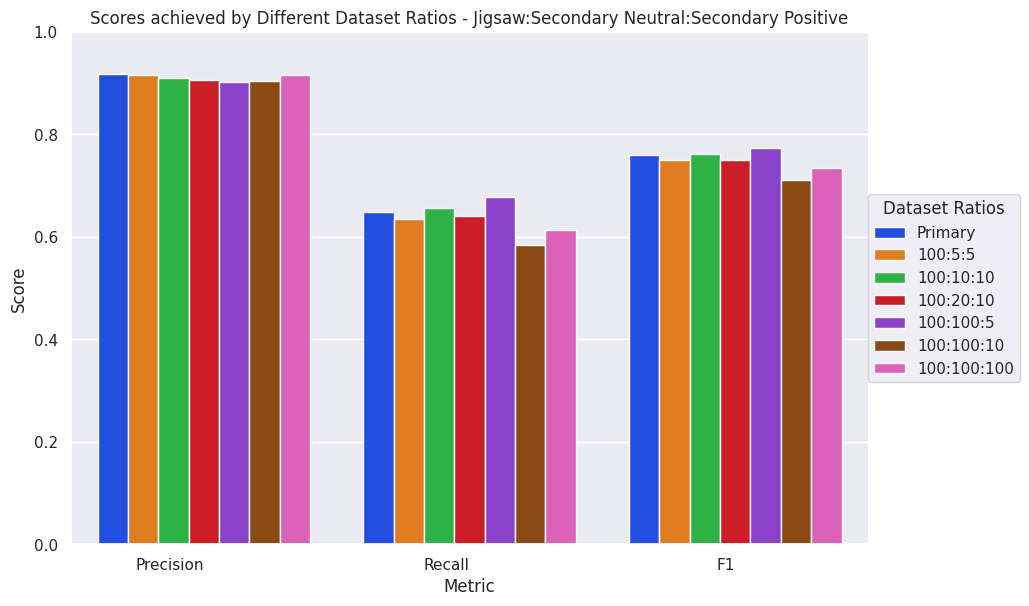

+-------------+--------+-----------+--------+
|    Ratio    | Recall | Precision |   F1   |
+-------------+--------+-----------+--------+
|   Primary   | 0.6494 |   0.9183  | 0.7608 |
|   100:5:5   | 0.6355 |   0.9155  | 0.7502 |
|  100:10:10  | 0.6561 |   0.9099  | 0.7624 |
|  100:20:10  | 0.6399 |   0.9067  | 0.7503 |
|  100:100:5  | 0.6771 |   0.9016  | 0.7734 |
|  100:100:10 | 0.5849 |   0.9051  | 0.7106 |
| 100:100:100 | 0.614  |   0.9164  | 0.7353 |
+-------------+--------+-----------+--------+


In [84]:
plot_ratio_scores(final_df)


In [85]:
datasets = ["jigsaw", "secondary_neutral", "secondary_positive"]
final_df = pd.DataFrame(columns=["Ratio", "Precision", "Recall", "F1"])
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)
        f1, precision, recall = [], [], []
        for dataset in datasets:
            d = data[dataset]
            f1.append(d['f1'])
            precision.append(d['precision'])
            recall.append(d['recall'])
        f1 = "{:5.4f} {:5.4f} {:5.4f}".format(*f1)
        precision = "{:5.4f} {:5.4f} {:5.4f}".format(*precision)
        recall = "{:5.4f} {:5.4f} {:5.4f}".format(*recall)
        new_row = {
            "Ratio": ratio, 
            "Precision (Jigsaw)": f1,
            "Recall (Jigsaw)": precision, 
            "F1 (Jigsaw)": recall
        }
    final_df = pd.concat([final_df, pd.DataFrame([new_row])], ignore_index=True)

In [86]:
datasets = [("jigsaw", "J"), ("secondary_neutral", "SN"), ("secondary_positive", "SP")]
final_df = pd.DataFrame(columns=["Ratio", "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                        "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"])
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)
        new_row = {
            "Ratio": ratio,
        }
        for (dataset, acronym) in datasets:
            d = data[dataset]
            new_row |= {
                f"Precision ({acronym})": "{:1.4f}".format(d['f1']),
                f"Recall ({acronym})": "{:1.4f}".format(d['precision']),
                f"F1 ({acronym})": "{:1.4f}".format(d['recall'])
            }

    final_df = pd.concat(
        [final_df, pd.DataFrame([new_row])], ignore_index=True)

In [87]:
def table_ratio_results(table_data):
    table = PrettyTable()
    table.field_names = ['Ratio', "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                         "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"]
    for _, row in table_data.iterrows():
        table.add_row([
            row['Ratio'],
            row['Precision (J)'],
            row['Recall (J)'],
            row['F1 (J)'],
            row['Precision (SN)'],
            row['Recall (SN)'],
            row['F1 (SN)'],
            row['Precision (SP)'],
            row['Recall (SP)'],
            row['F1 (SP)']
        ])
    print("Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive")
    print(table)
    print("Key: J = Jigsaw | SN = Secondary Neutral | SP = Secondary Positive")

In [88]:
table_ratio_results(final_df)

Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive
+-------------+---------------+------------+--------+----------------+-------------+---------+----------------+-------------+---------+
|    Ratio    | Precision (J) | Recall (J) | F1 (J) | Precision (SN) | Recall (SN) | F1 (SN) | Precision (SP) | Recall (SP) | F1 (SP) |
+-------------+---------------+------------+--------+----------------+-------------+---------+----------------+-------------+---------+
|   Primary   |     0.7608    |   0.9183   | 0.6494 |     0.5608     |    0.9792   |  0.3929 |     0.0000     |    0.0000   |  0.0000 |
|   100:5:5   |     0.7502    |   0.9155   | 0.6355 |     0.4066     |    0.3778   |  0.4402 |     0.9818     |    1.0000   |  0.9643 |
|  100:10:10  |     0.7624    |   0.9099   | 0.6561 |     0.5147     |    0.4915   |  0.5403 |     0.9777     |    1.0000   |  0.9563 |
|  100:20:10  |     0.7503    |   0.9067   | 0.6399 |     0.4942     |    0.4790   |  0.5104 |   

In [89]:
def compare_primary_secondary(df):
    df_melt = df.melt(id_vars=['Model'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Model'].unique()))

    g = sns.catplot(x='score', y='value', hue='Model', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Models', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Models")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Model', 'Recall', 'Precision', 'F1', 'ROC-AUC']
    for _, row in df.iterrows():
        table.add_row([row['Model'], row['Recall'], row['Precision'], row['F1'], round(row['ROC-AUC'], 4)])
    print(table)

In [90]:
json_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1-step=11176_test_results.json',
    "Secondary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
}
final_df = pd.DataFrame()
for model, json_path in json_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)['secondary_neutral']
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1', 'auc']]
        df['model'] = model
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'auc': "ROC-AUC",
    'model': 'Model'
})

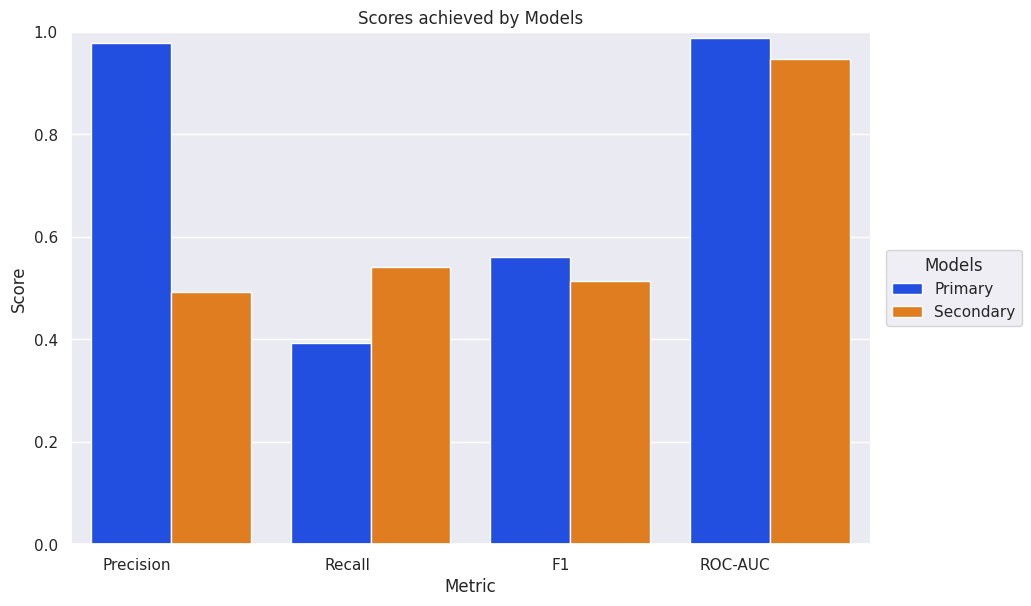

+-----------+--------+-----------+--------+---------+
|   Model   | Recall | Precision |   F1   | ROC-AUC |
+-----------+--------+-----------+--------+---------+
|  Primary  | 0.3929 |   0.9792  | 0.5608 |  0.9876 |
| Secondary | 0.5403 |   0.4915  | 0.5147 |  0.9477 |
+-----------+--------+-----------+--------+---------+


In [91]:
compare_primary_secondary(final_df)

In [92]:
def confusion_matrix(confusion_dict):
    table = PrettyTable()
    table.field_names = ['', 'Actual Positive', 'Actual Negative']
    
    table.add_row(['Predicted Positive', confusion_dict['tp'], confusion_dict['fp']])
    table.add_row(['Predicted Negative', confusion_dict['fn'], confusion_dict['tn']])
    
    print(table)

In [93]:
confusion_matrix_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json'
with open(confusion_matrix_data, 'r') as f:
    data = json.load(f)

confusion_data = data['secondary_positive']['confusion_matrix']
confusion_matrix(confusion_data)

+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |       243       |        0        |
| Predicted Negative |        9        |        0        |
+--------------------+-----------------+-----------------+
